---
## Imports
---

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

# Load train data
train_path = "/content/drive/MyDrive/Project Data/train.csv"
#train_path = "Project Data-20250507/train.csv"
train_df = pd.read_csv(train_path)

# View shape and features
print("Training data shape:", train_df.shape)
print("\nTraining data columns:", train_df.columns.tolist())

# Display first few rows
print("\nFirst 5 rows of training data:")
train_df.head()

Mounted at /content/drive
Training data shape: (9543, 2)

Training data columns: ['text', 'label']

First 5 rows of training data:


,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


---
## Set the seed for reproducibulity
---

In [5]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

---
## Data split into train and validation
---

In [6]:
# Train + Val split 80/20
X_train, X_val, y_train, y_val = train_test_split(
    train_df["text"], train_df["label"],
    test_size=0.2, stratify=train_df["label"], random_state=42
)

---
## Prepare hugging face DatasetDict
---
This stores data splits in an accessible way for other hugging face tools

In [7]:
dataset = DatasetDict({
    "train": Dataset.from_dict({"text": X_train.tolist(), "label": y_train.tolist()}),
    "validation": Dataset.from_dict({"text": X_val.tolist(), "label": y_val.tolist()}),
})

---
## Use roberta tokenizer
---

In [8]:
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, max_length=64)

tokenized = dataset.map(tokenize_function, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

---
## Show an example of a tweet: original and tokenized
---

In [9]:
# Show one example from the training set
sample = tokenized["train"][0]

# Decode the input_ids back into readable text
decoded_text = tokenizer.decode(sample["input_ids"])

# Display nicely
print("Original Text:")
print(dataset["train"][0]["text"])
print("\nTokenized Input IDs:")
print(sample["input_ids"])
print("\nDecoded (Recovered) Text:")
print(decoded_text)
print("\nAttention Mask:")
print(sample["attention_mask"])
print("\nLabel:")
print(sample["label"])

Original Text:
Nasdaq prices 600M of 0.875% senior notes

Tokenized Input IDs:
[0, 487, 281, 5946, 850, 5594, 448, 9, 321, 4, 29271, 207, 949, 2775, 2]

Decoded (Recovered) Text:
<s>Nasdaq prices 600M of 0.875% senior notes</s>

Attention Mask:
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Label:
2


---
## Dynamic padding collator
---
Data collators are objects that will form a batch by using a list of dataset elements as input

In [10]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

---
## Compute metrics
---

In [11]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="macro"),
        "precision": precision_score(labels, preds, average="macro"),
        "recall": recall_score(labels, preds, average="macro"),
    }

---
## Training arguments
---

In [12]:
training_args = TrainingArguments(
    output_dir="./results/roberta_full",
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs/roberta_full",
    report_to="none"
)

---
## Load model and trainer
---

In [13]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-13-2863397091>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


---
## Train the model
---

In [14]:
trainer.train()

Step,Training Loss
500,0.548100
1000,0.430800
1500,0.318600
2000,0.307700
2500,0.196500


TrainOutput(global_step=2865, training_loss=0.34106545439981456, metrics={'train_runtime': 366.0833, 'train_samples_per_second': 62.56, 'train_steps_per_second': 7.826, 'total_flos': 555225839679420.0, 'train_loss': 0.34106545439981456, 'epoch': 3.0})

---
## Evaluate on validation
---

In [15]:
preds = trainer.predict(tokenized["validation"])
y_pred = np.argmax(preds.predictions, axis=1)
y_true = np.array(tokenized["validation"]["label"])
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       288
           1       0.85      0.89      0.87       385
           2       0.94      0.92      0.93      1236

    accuracy                           0.90      1909
   macro avg       0.87      0.88      0.87      1909
weighted avg       0.90      0.90      0.90      1909



---
## Confusion Matrix
---

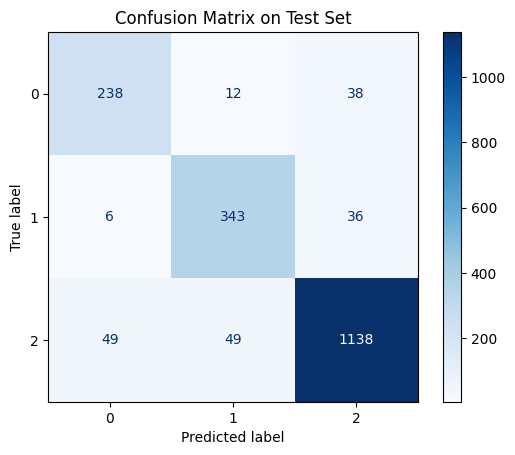

In [16]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Test Set")
plt.show()